In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(0)

## Modulator design

Wavelength = 0.13776 nm
Thickness for pi phase shift = 1.889 microns
Absorption = 0.79
Maximum phase shift = 2.96


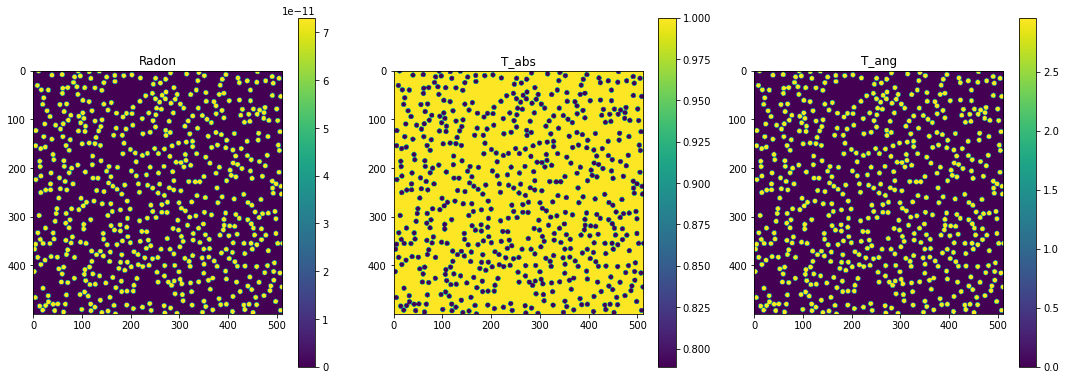

In [37]:
def calculate_delta_and_beta_tungsten():

    rho_a = 6.0221e23*19.25*1e6/183.84 # atomic number density tungsten, atoms/m^3
    f1=7.391e1 # tungsten value 39 keV
    f2=1.7219 # tungsten value 39 keV

    electron_radius = 2.8179403262e-15

    factor = electron_radius*rho_a*wavelength**2/(2*np.pi) 
    beta = factor*f2
    delta = factor*f1

    # delta = 2.0958531068493e-06 # http://purple.iptm.ru/xcalc/xcalc_mysql/ref_index.php tungsten 39keV
    # beta = 5.1036163210706e-08
    
    delta = 3.645703245482E-05 # tungsten 9keV
    beta = 2.5977314266174E-06 # tungsten 9keV
    
    return delta, beta

def create_modulator(ny,nx, pixel_size,radius,nb_of_points):

    modulator = np.zeros((nx,ny))

    NY = np.linspace(0,ny-1,ny) #- ny//2
    NX = np.linspace(0,nx-1,nx) #- nx//2
    NY, NX = np.meshgrid(NY,NX)
    NY, NX = pixel_size*NY, pixel_size*NX

    center_coordinates = []
    counter = 0
    while counter < nb_of_points:
        x_ctr_coordinates = nx*np.random.rand(1)*pixel_size
        y_ctr_coordinates = ny*np.random.rand(1)*pixel_size

        modulator2 = modulator + np.where( (NX-x_ctr_coordinates)**2 + (NY-y_ctr_coordinates)**2 <= radius**2, 1 , 0)
        if (modulator2>1).any(): # if >1, there is overlap of balls. then skip
            pass
        else: # else, add it to the modulator
            modulator = modulator2
            counter += 1
            center_coordinates.append((x_ctr_coordinates,y_ctr_coordinates))

    # fig, ax = plt.subplots()
    # ax.imshow(modulator)

    return modulator, center_coordinates

c = 299792458    # Velocity of Light [m/s]
plank = 4.135667662E-15  # Plank constant [ev*s]
const = plank * c
energy = 9e3 # eV
wavelength =  const / energy   # [m]  wavelenght 
k = 2*np.pi/wavelength
print(f'Wavelength = {wavelength*1e9:.5f} nm')

ny, nx = 512, 500
pixel_size = 60 # nm
nb_of_points = 600
radius = 300 # nm
sample_thickness = 2e-6 #m

modulator_mask,_ = create_modulator(ny,nx, pixel_size,radius,nb_of_points)

delta_value, beta_value = calculate_delta_and_beta_tungsten()
# print(f'delta = {delta_value} \t beta: {beta_value}')

delta = delta_value*modulator_mask
beta  = beta_value*modulator_mask

pi_shift = np.pi/k/delta_value
print(f"Thickness for pi phase shift = {pi_shift*1e6:.3f} microns")

radon = sample_thickness*(delta-1j*beta)
transmission = np.exp(-1j*k*radon)

print(f"Absorption = {np.min(np.abs(transmission)):.2f}")
print(f"Maximum phase shift = {np.max(np.angle(transmission)):.2f}")
# wavefront = abs( pj.propagation(transmission, z2, pixeldet, energy, magn, adjoint = False) ) # Forward projection
# intensity = np.abs(wavefront)**2

fig, ax = plt.subplots(1,3,figsize=(15,10))
ax0 = ax[0].imshow(np.abs(radon))
ax[0].set_title('Radon')
ax1 = ax[1].imshow(np.abs(transmission))
ax[1].set_title('T_abs')
ax2 = ax[2].imshow(np.angle(transmission))
ax[2].set_title('T_ang')
fig.colorbar(ax0, ax=ax[0],shrink=0.5)
fig.colorbar(ax1, ax=ax[1],shrink=0.5)
fig.colorbar(ax2, ax=ax[2],shrink=0.5)
fig.tight_layout()